# Homework 2 (HW2)

By the end of this homework, we expect you to be able to:

- Preprocess data and make it amenable to statistical analysis and machine learning models;
- Train and test out-of-the-box machine learning models in `sklearn`;
- Carry out simple multivariate regression analyses using `statsmodels`;
- Use propensity score matching to estimate treatment effects;

---

## Important Dates

- Homework release: Fri 15 Nov 2024
- **Homework due**: Fri 29 Nov 2024, 23:59
- Grade release: Mon 09 Dec 2024

---

##  Some rules

1. You are allowed to use any built-in Python library that is included in the `requirements.txt` for this homework. If you use any additional library, this may complicate the grading process, and we reserve the right to penalize your grade for unnecessary complexity of the solution. All the questions can be solved with the libraries in `requirements.txt`.
2. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a single notebook (plus the required data files) in the *master/main* branch. If there are multiple notebooks present, we will **not grade** anything.
3. We will **not run your notebook for you**! Rather, we will grade it as is, which means that only the results contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.
4. In continuation to the previous point on additional library, interactive plots, such as those generated using `plotly`, should be **strictly avoided**!

**A Note on using Language Models (LMs)**

If you try hard enough, you will likely get away with cheating. Fortunately, our job is not to police, but rather to educate! So, please consider the following:

Presumably, you are taking this course to learn something! LMs are not always right ([they often fail in silly ways](https://community.openai.com/t/why-9-11-is-larger-than-9-9-incredible/869824/4)). This course should prepare you to detect when they are wrong!
Some of the TAs on this course literally published many works on detecting machine-generated text.

Here LLM includes but not limited to chatbots like ChatGPT, coding assistants like Copilot. Do not even use them to prettify your code or correct English. If you are caught using LLMs, you will be reported to the instructor and subject to the consequences. 


---


## Grading 
- The homework has a total of 100 points, distributed as follows:
    - Part 1: Data Preprocessing ( 20 points)
    - Part 2: Linear Regression (30 points)
    - Part 3: Supervised Learning (40 points)
    - Part 4: Propensity Score Matching (10 points)

## Context

Within EPFL's master program, you are excited to start an internship as a data scientist.
After rounds of interviews, you have been selected to work with the biggest car dealership in Switzerland !

Your mentor at the company Tim, has explained to you that the company is interested in a pricing model for used cars. 

- Tim: "We have a lot of used cars in our inventory, and we need to determine the price at which we should sell these cars. We have some ideas about the factors that influence the price of a used car, but so far we have just been using our experience and intuition to determine the price of a used car. Sometimes it works, but probably we can do better and a more data-driven approach would also help our new employees in the sales team as they have less experience."

- You: "That sounds like a great project! What kind of data do we have?"

- Tim: "We sell all kinds of cars here, but maybe we can start with a specific brand and model. For example, the Toyota Corolla is the best-selling car worldwide in 2023, and we have a lot of data on it. We can start by analyzing the data on used Toyota Corolla cars. If it works well, we can extend the analysis to other brands."

The dataset contains the following columns:

- `Age`: Age of the car in months.
- `Mileage`: Number of distance the car has been driven. (km or miles)
- `FuelType`: Fuel type of the car (Petrol, Diesel, or CNG)
- `HP`: Horsepower
- `MetColor`: Is the color of the car metallic? (Yes=1, No=0)
- `Automatic`: Is the car automatic? (Yes=1, No=0)
- `CC`: Cylinder volume in cubic centimeters
- `Doors`: Number of doors
- `Weight`: Weight of the car in kilograms
- `Price`: Price of the car in euros


## Data

The data is provided in the `data` folder and it contains the following 3 csv files:
- `Task1-2.ToyotaCorolla-clean.csv` and `Task1-2.ToyotaCorolla-raw.csv` for Part 1 and Part 2
- `Task3.ToyotaCorolla_sales_3months.csv` for Part 3
- `Task4.ToyotaCorolla_discount_sales` for Part 4

You should not use any other data source for this homework.

## References:

The data is based on the ToyotaCorolla dataset from the UCI Machine Learning Repository [here](https://archive.ics.uci.edu/ml/datasets/Toyota+Corolla).
We have made some modifications to the original dataset, so please use the data provided in the `data` folder in the course repo.

## Task 1 (20 pts) - Get to know the data

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
import sklearn

# fix random seed for reproducibility
np.random.seed(42)
random.seed(42)

# additional imports
import warnings
from IPython.display import Latex
from scipy.stats import pearsonr, spearmanr # confirmed that we can use it on ED (#430)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score as f1_score_sk, root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
import networkx as nx # Allowed by TA on Ed (#423)


**1.1 (2 pts)**: Load the data from the file `Task1-2.ToyotaCorolla-raw.csv` into a pandas DataFrame. Display the first 5 rows of the DataFrame. Hint: A naive loading of the data will raise an error. You will need to figure out how to load the data correctly. (Hint: localise which row is causing the error)

In [221]:
def print_bad_lines(bad_line:list[str])->None:
    print(f"A bad line : {bad_line}")

data = pd.read_csv(r"data/Task1-2.ToyotaCorolla-raw.csv", on_bad_lines=print_bad_lines, engine='python')

def on_bad_lines(bad_line:list[str])->list[str]:
    bad_line[0] = bad_line[0] + bad_line[1]
    bad_line.pop(1)
    print(f"Corrected line : {bad_line}")
    return bad_line

data = pd.read_csv(r"data/Task1-2.ToyotaCorolla-raw.csv", on_bad_lines=on_bad_lines, engine='python')
display(data.head())

A bad line : ['15', '646.9', '22', '21862.732919254657', 'Petrol', '97', '1', '0', '1400', '3', '1100', 'GBP']
Corrected line : ['15646.9', '22', '21862.732919254657', 'Petrol', '97', '1', '0', '1400', '3', '1100', 'GBP']


,Price,Age,Mileage,FuelType,HP,MetColor,Automatic,CC,Doors,Weight,Currency
0,13500.0,23.0,46986.0,Diesel,90.0,1.0,0.0,2000.0,3.0,1165.0,EURO
1,11878.0,23.0,72937.0,Diesel,90.0,1.0,0.0,2000.0,3.0,1165.0,CHF
2,12050.0,24.0,41711.0,Diesel,90.0,1.0,0.0,2000.0,3.0,1165.0,CHF
3,12914.0,26.0,48000.0,Diesel,90.0,0.0,0.0,2000.0,3.0,1165.0,CHF
4,11878.0,30.0,38500.0,Diesel,90.0,0.0,0.0,2000.0,3.0,1170.0,CHF


**1.2 (2 pts)**: Check if there are nan values in the Dataframe. If there are, try to find out which row is problematic and fix it. If you can't fix it, drop the row.

In [222]:
print("Nan row(s):")
display(data.loc[data.isna().sum(axis=1).astype(bool)])

Nan row(s):


,Price,Age,Mileage,FuelType,HP,MetColor,Automatic,CC,Doors,Weight,Currency
906,8423.0;68;58860.0;Petrol;110;1;0;1600;3;1055;CHF,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None


**Answer**

Line number 906 is problematic because all the data fields were inputted inside the `Price` data field. This is probably because the person who logged this input added semicolon separators, but comma separators are needed for the `csv` format. We correct this row by splitting the input at the semicolons and enter the split inputs in each column.

In [223]:
problematic_id = data.isna().sum(axis=1).astype(bool).idxmax() # since there is only one id

with warnings.catch_warnings():
    warnings.simplefilter("ignore") # Ignore Pandas deprecation warnings related to dtypes
    data.loc[problematic_id] = data.loc[problematic_id]["Price"].split(";")

print("Corrected nan row:")
display(data.loc[problematic_id:problematic_id, :])

Corrected nan row:


,Price,Age,Mileage,FuelType,HP,MetColor,Automatic,CC,Doors,Weight,Currency
906,8423.0,68,58860.0,Petrol,110,1,0,1600,3,1055,CHF


**1.3 (4 pts): Compute the mean, median of the `Price` column.**

1. Compute the mean and median of the `Price` column. If you encounter error, try to understand why this error is happening and propose a solution.
2. After computing the mean and median, do you think they are reasonable? If not, what could be the reason for this? 
  
Hint: Is all values in the `Price` column numerical?


In [224]:
print(f'Description of the Price column:\n{data["Price"].describe()}\n')
print(f"Dataframe dtypes:\n{data.dtypes}")

Description of the Price column:
count       1437
unique       312
top       7731.0
freq          94
Name: Price, dtype: object

Dataframe dtypes:
Price        object
Age          object
Mileage      object
FuelType     object
HP           object
MetColor     object
Automatic    object
CC           object
Doors        object
Weight       object
Currency     object
dtype: object


**Answer**

As we can see we cannot directly compute the mean and median of the `Price` column because the dtype of this column is an `object` or more specifically a `string`. Let us convert it to the `float` dtype.

In [225]:
data = data.astype(float, errors='ignore')
print(f"Dataframe dtypes:\n{data.dtypes}")

Dataframe dtypes:
Price         object
Age          float64
Mileage       object
FuelType      object
HP           float64
MetColor     float64
Automatic    float64
CC           float64
Doors        float64
Weight       float64
Currency      object
dtype: object


**Answer**

As we can see above, even when trying to cast the dataframe in the `float` dtype, the `Price` column is still an `object`. This means that there are `strings` which cannot be converted to `float` within the column, and these are hindering the conversion process. Below we find these problematic instances and then replace them.

In [226]:
def find_problementic_conversions(data:pd.DataFrame, column_name:str)->None:
    print(f"{column_name} Conversion Errors :")
    for value in data[column_name]:
        try:
            float(value)
        except:
            print(f"\t• {value}")

find_problementic_conversions(data, "Price")
find_problementic_conversions(data, "Mileage")

Price Conversion Errors :
	• 15,398,499999999998
	• 19,817.949999999997
	• 14,851.099999999999
	• 14,851.099999999999
	• 11,424.099999999999
	• 10,877.849999999999
	• 11,871.449999999999
	• 11,871.449999999999
	• 12,017.499999999998
	• 9,864£
	• 9,834£
	• 13,659.699999999999
	• 11,816.249999999998
	• 7,898.2£
	• 9,884.25
	• 8,842.349999999999
	• 8,449.999
	• 7,992.499999999999
	• 8,890.65
	• 6,406.65
	• 7,302.499999999999
	• 5,610.0
	• 8,625.0
	• 6,855.15
	• 9,387.449999999999
	• 9,686.449999999999
	• 4,089.9999
Mileage Conversion Errors :
	• ß7787.0


In [227]:
replacements = {
    "Price":{
        "15,398,499999999998" : "15398.499999999998",
        ",":"",
        "£":""
    },
    "Mileage": {
        "ß" : ""
    }
}

for column_name, replacement_dict in replacements.items():
    for old_string, new_string in replacement_dict.items():
        data[column_name] = data[column_name].str.replace(old_string, new_string)

data = data.astype(float, errors='ignore')
print(f"Dataframe dtypes:\n{data.dtypes}")

display(data["Price"].describe().to_frame().loc[["mean", "50%"]].rename(index={"50%":"median"}))

Dataframe dtypes:
Price        float64
Age          float64
Mileage      float64
FuelType      object
HP           float64
MetColor     float64
Automatic    float64
CC           float64
Doors        float64
Weight       float64
Currency      object
dtype: object


,Price
mean,9439.50581
median,8595.00000


**Answer**

The prices shown above seem reasonable, but an issue stems from the currency used. Indeed, the data contains a mix of currencies (CHF, EUR, and GB) which cannot be compared together to obtain a meaningful mean or a median. Below, we therefore convert the units.

**1.4 (4 pts): Convert Units**

From now on, we will work with the cleaned data `Task1-2.ToyotaCorolla-clean.csv`. Read it into a DataFrame.

You notice that some prices are in CHF (Swiss Francs), while others are in EUR (Euros) or GBP (British Pounds). Additionally, for cars priced in GBP, the mileage is in miles rather than kilometers.

For consistency, convert all prices to CHF and all distances to kilometers.

- Exchange rates:
  - 1 CHF = 1.05 EUR
  - 1 GBP = 1.15 CHF
  - 1 mile = 1.61 km

Make the following conversions:
1. Convert prices in EUR or GBP to CHF, rounding to the nearest integer.
2. Convert distances in miles (for GBP cars) to kilometers, rounding to the nearest integer.
3. Drop the 'Currency' column.
4. Calculate the min, mean, median and max of the 'Price' and 'Distance' columns after the conversion.

In [228]:
data = pd.read_csv(r"data/Task1-2.ToyotaCorolla-clean.csv", on_bad_lines="warn")
display(data.head())

,Price,Age,Mileage,FuelType,HP,MetColor,Automatic,CC,Doors,Weight,Currency
0,13500.0,23,46986.0,Diesel,90,1,0,2000,3,1165,EURO
1,11878.0,23,72937.0,Diesel,90,1,0,2000,3,1165,CHF
2,12050.0,24,41711.0,Diesel,90,1,0,2000,3,1165,CHF
3,12914.0,26,48000.0,Diesel,90,0,0,2000,3,1165,CHF
4,11878.0,30,38500.0,Diesel,90,0,0,2000,3,1170,CHF


In [229]:
data["Mileage"] = (data["Mileage"] * (1 + 0.61 * (data["Currency"] == "GBP"))).round()
data["Price"] = (data["Price"] * (
    (1/1.05) * (data["Currency"] == "EURO")
    + 1.15 * (data["Currency"] == "GBP")
    + 1 * (data["Currency"] == "CHF")
)).round()
data.drop(columns="Currency", inplace=True)
display(data.describe().loc[["min", "mean", "50%", "max"], ["Price", "Mileage"]].rename(index={"50%":"median"}))

,Price,Mileage
min,3758.000000,1.000000
mean,9423.536212,68533.259749
median,8595.000000,63389.500000
max,28074.000000,243000.000000


**1.5 (2 pts): Analyze Average Price**

A.  Print the average price for each fuel type. Determine which fuel type has the highest average price.

B.  Print the average price for different numbers of doors. Determine which number of doors has the highest average price.

In [230]:
# A
display(data.groupby("FuelType").mean()["Price"].to_frame(name="Average Price"))

,Average Price
FuelType,
CNG,8383.235294
Diesel,9878.619355
Petrol,9381.722310


**Answer**

The `diesel` fuel type has the highest average price.

In [231]:
# B
display(data.drop(columns="FuelType").groupby("Doors").mean()["Price"].to_frame("Average Price"))

,Average Price
Doors,
2,6997.500000
3,8898.673633
4,8604.384058
5,10082.823442


**Answer**

The `5` doors types of cars have the highest average price.

**1.6 (2 pts): Relationship Between Car Age and Price**

It is intuitive that an older car tends to be cheaper, and a car with more mileage might also be less expensive. 

To explore this intuition, create two scatter plots:
1. Car Age vs Price
2. Mileage vs Price

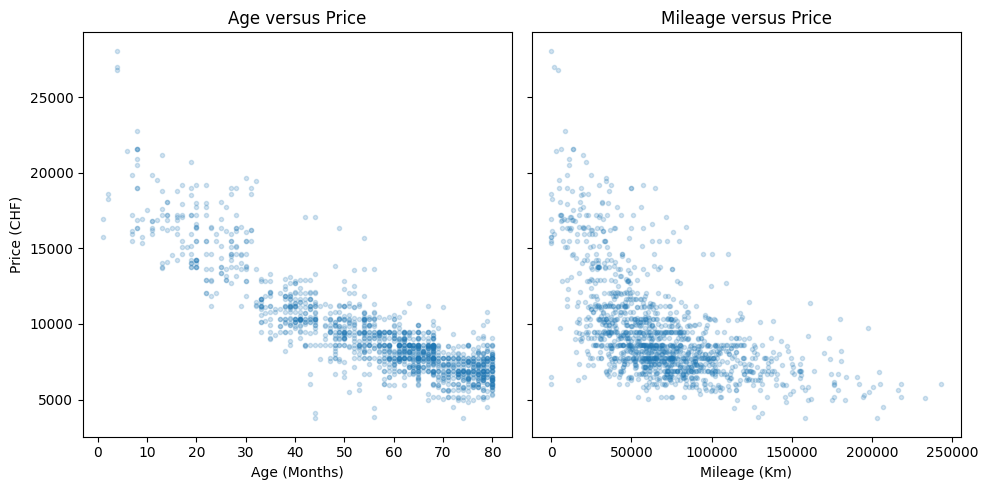

In [232]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

ax1.plot(data["Age"], data["Price"], ".", alpha=0.2)
ax1.set_xlabel("Age (Months)")
ax1.set_ylabel("Price (CHF)")

ax1.set_title("Age versus Price")

ax2.plot(data["Mileage"], data["Price"], ".", alpha=0.2)
ax2.set_xlabel("Mileage (Km)")

ax2.set_title("Mileage versus Price")

plt.tight_layout()
plt.show()

**1.7 (4 pts): Correlation Between Price and Mileage**

The relationship between car price and mileage appears non-linear, with a steeper price drop initially followed by a flatter curve.

A.(2 pts)  Calculate both the Pearson and Spearman correlations between the price of the car and the distance driven.


In [233]:
pearson = pearsonr(data["Mileage"], data["Price"])
spearnman = spearmanr(data["Mileage"], data["Price"])
print(
    f"""Correlations between the price of the car and the distance driven :
    \t• Pearson : {pearson.correlation:.3f}\t(p_value = {pearson.pvalue:.2e})
    \t• Spearman : {spearnman.correlation:.3f}\t(p_value = {spearnman.pvalue:.2e})"""
)

Correlations between the price of the car and the distance driven :
    	• Pearson : -0.563	(p_value = 4.49e-121)
    	• Spearman : -0.605	(p_value = 2.60e-144)



B.(2 pts)  Which correlation value is higher? Does this result align with your expectations?

**Answer**

Spearman's correlation is higher (in absolute terms) than Pearson's correlation. This is expected, as the relation is non-linear, and Pearson's correlation is a measure of linear correlation, while Spearman's correlation accounts for non-linearity.

## Part 2 Linear Regression (30 pts)

You want to build a linear regression model to predict the price of a car based on the features you have.



**2.0 (8 pts) Helper functions**

Before building machine learning models, how to asses performance is crucial. Hence we first implement some helper functions to asses the performance of our model. We can use these later throughout the exercise.

Implement the `accuracy` , `precision`, `recall` and `f1_score` functions with the following requirements:

1. These functions should take in the true labels(`np.array`) and the predicted labels(`np.array`) and return the corresponding metric. 
2. They should follow the convention that the positive class is 1 and the negative class is 0.
3. Apply the functions to the following data:

```python
true_labels = np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0])
predicted_labels = np.array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0])
```

Compare the results with the implementation in `sklearn` and see if they match.

In [234]:
def accuracy(true_labels:np.ndarray, predicted_labels:np.ndarray)->float:
    return np.mean(true_labels == predicted_labels)

def true_false_positives_negatives(true_labels:np.ndarray, predicted_labels:np.ndarray)->tuple[float, float, float, float]:
    tp = np.sum((predicted_labels == 1) & (true_labels == 1))
    tn = np.sum((predicted_labels == 0) & (true_labels == 0))
    fp = np.sum((predicted_labels == 1) & (true_labels == 0))
    fn = np.sum((predicted_labels == 0) & (true_labels == 1))
    return tp, tn, fp, fn

def precision(true_labels:np.ndarray, predicted_labels:np.ndarray, tp:float=None, fp:float=None)->float:
    if tp is None or fp is None:
        tp, _, fp, _ = true_false_positives_negatives(true_labels, predicted_labels)
    return tp/(tp+fp)

def recall(true_labels:np.ndarray, predicted_labels:np.ndarray, tp:float=None, fn:float=None)->float:
    if tp is None or fn is None:
        tp, _, _, fn = true_false_positives_negatives(true_labels, predicted_labels)
    return tp/(tp+fn)

def f1_score(true_labels:np.ndarray, predicted_labels:np.ndarray)->float:
    tp, _, fp, fn = true_false_positives_negatives(true_labels, predicted_labels)
    precision_score = precision(true_labels, predicted_labels, tp=tp, fp=fp)
    recall_score = recall(true_labels, predicted_labels, tp=tp, fn=fn)
    return (2*precision_score*recall_score) / (precision_score+recall_score)

In [235]:
true_labels = np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0])
predicted_labels = np.array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0])

for sklearn_score, custom_score in zip([accuracy_score, precision_score, recall_score, f1_score_sk], [accuracy, precision, recall, f1_score]):
    print(f"{custom_score.__name__.capitalize().replace('_', ' ')} :")
    sklearn_result = sklearn_score(true_labels, predicted_labels)
    custom_result = custom_score(true_labels, predicted_labels)
    print(f"\t• sklearn : {sklearn_result:.3f}")
    print(f"\t• custom  : {custom_result:.3f}")
    assert np.allclose(sklearn_result, custom_result)
print("\nThe results match with sklearn!")

Accuracy :
	• sklearn : 0.700
	• custom  : 0.700
Precision :
	• sklearn : 0.667
	• custom  : 0.667
Recall :
	• sklearn : 0.800
	• custom  : 0.800
F1 score :
	• sklearn : 0.727
	• custom  : 0.727

The results match with sklearn!



**2.1 (6 pts) Preprocess the Data**

To prepare your data for building a linear regression model, complete the following steps:

A.(1 pts) Convert the categorical variables to one-hot encoding using the `pd.get_dummies()` function, how many columns do you have after the one-hot encoding? (P.S. You may want to avoid introducing multicollinearity with one-hot encoding, what should you do to avoid this?)


In [236]:
data_ohe = pd.get_dummies(
    data=data, 
    drop_first=True, # avoid introducing multicollinearity
    columns=["FuelType", "Doors"], # `Doors` is one hot encoded because it represents distinct categories or groups rather than a continuous numeric quantity. See post #467 on ed forum.
    dtype=int
)

display(data_ohe)

,Price,Age,Mileage,HP,MetColor,Automatic,CC,Weight,FuelType_Diesel,FuelType_Petrol,Doors_3,Doors_4,Doors_5
0,12857.0,23,46986.0,90,1,0,2000,1165,1,0,1,0,0
1,11878.0,23,72937.0,90,1,0,2000,1165,1,0,1,0,0
2,12050.0,24,41711.0,90,1,0,2000,1165,1,0,1,0,0
3,12914.0,26,48000.0,90,0,0,2000,1165,1,0,1,0,0
4,11878.0,30,38500.0,90,0,0,2000,1170,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,6479.0,69,20544.0,86,1,0,1300,1025,0,1,1,0,0
1432,9369.0,72,19000.0,86,0,0,1300,1015,0,1,1,0,0
1433,7343.0,71,17016.0,86,0,0,1300,1015,0,1,1,0,0
1434,6263.0,70,16916.0,86,1,0,1300,1015,0,1,1,0,0


**Answer**

As seen above, we have 13 columns after one-hot encoding. To avoid multicolinearity, we use `drop_first = True`, which removes the first encoded dummy variable, as it is fully explainable with the other variables.

B.(1 pts) Split the data into features (X) and target (y) variables. The target variable is the 'Price' column. Then split the data into train test sets using a 80-20 split. Use `random_state=42` for reproducibility. How many samples are in the training set and how many samples are in the test set?


In [237]:
def seperate_features_from_target(df:pd.DataFrame, target_name:str)->tuple[pd.DataFrame, pd.DataFrame]:
    return df.drop(columns=target_name), df[target_name].to_frame()

In [238]:
X, y = seperate_features_from_target(data_ohe, target_name="Price")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1148, 12), (1148, 1), (288, 12), (288, 1))

**Answer**

As shown above, we have 1148 samples in the train set, and 288 in the test set.

C.(1 pts) Why do we split the data into only train-test sets but not train-validation-test sets? 

**Answer**

We only split the data into only train-test sets but not train-validation-test sets because we have a relatively small dataset size. If we were to introduce one more split, our training data size would decrease even further.

Additionally, we are not searching for any hyperparameters at the moment. We only want an estimation of the error on new data. Therefore, there is currently no need for a train-validation-test split.

D.(1 pts) **Standardize the Features**: Use `StandardScaler` from `sklearn.preprocessing` and then add a constant column using `sm.add_constant()`. Print the average and standard deviation of the training set after standardization.

In [239]:
def standardize_features(X_train:pd.DataFrame, X_test:pd.DataFrame, add_constant:bool=True)->tuple[pd.DataFrame, pd.DataFrame]:
    stdizer = StandardScaler().set_output(transform="pandas")
    X_train_std = stdizer.fit_transform(X_train)
    X_test_std = stdizer.transform(X_test)
    if add_constant:
        X_train_std, X_test_std = map(sm.add_constant, [X_train_std, X_test_std])
    return X_train_std, X_test_std

X_train_std, X_test_std = standardize_features(X_train, X_test, add_constant=True)
display(X_train_std.describe().loc[["mean", "std"]].T)

,mean,std
const,1.000000e+00,0.000000
Age,1.485455e-16,1.000436
Mileage,-1.485455e-16,1.000436
HP,3.868373e-17,1.000436
MetColor,-7.736746e-17,1.000436
Automatic,4.642047e-18,1.000436
CC,-2.963174e-16,1.000436
Weight,-6.854757e-16,1.000436
FuelType_Diesel,1.005777e-17,1.000436
FuelType_Petrol,2.321024e-17,1.000436


**Answer**

As expected, we see that the average is close to 0 and the standard deviation close to 1, except of course, for the `const` column.

E.(2 pts) Should we first standardize the data and then split it into train and test sets or vice versa?   why?

**Answer**

It is better to first split the data, and then standardize both the train and test data with respect to the train data. Indeed, the entire pipeline must be built on the train data only.

**2.2 (10 pts) Train and Evaluate the Linear Regression Model**

To train and evaluate a linear regression model using the `statsmodels` library, complete the following steps:

1. (2 pts) Train a linear regression model on the training dataset using `sm.OLS` from `statsmodels`, print the summary of the model using `model.summary()`.


In [240]:
model = sm.OLS(endog=y_train, exog=X_train_std, hasconst=True)
np.random.seed(42)
model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     536.0
Date:                Wed, 27 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:29:26   Log-Likelihood:                -9803.5
No. Observations:                1148   AIC:                         1.963e+04
Df Residuals:                    1135   BIC:                         1.970e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            9441.4983     36.725    2

2. (2 pts) Evaluate the model on the test dataset using the square root of the mean squared error (RMSE) metric. 
   1. Report the RMSE value.


In [241]:
# 1
test_rmse = root_mean_squared_error(y_test, model.predict(X_test_std))

display(Latex(f"$RMSE_{{test}} = {test_rmse:.3f}$ (CHF)"))

<IPython.core.display.Latex object>

2. Your boss wants to know how far off the model's predictions are from the actual price of the car. What would you tell him? Given a number and explain how you got it.



In [242]:
mean_y_test = y_test.mean().values[0]
display(Latex(f"The mean price of cars in the test set :\t$\mu_{{test}} = {mean_y_test:.3f}$ (CHF)"))
display(Latex(f"The error on these prices :\t$RMSE_{{test}} = {test_rmse:.3f}$ (CHF)"))
display(Latex(f"$\mu_{{test}} / RMSE_{{test}} = {test_rmse/mean_y_test:.3%}$%"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

**Answer**

To quantify how far off the model's predictions are, we calculate the mean price of cars in the test set, and the error on these prices (RMSE; see above). By dividing these values, we show that the model's predictions are, on average, off about 15.337% from the actual price of the car. Below is a plot to illustrate it.

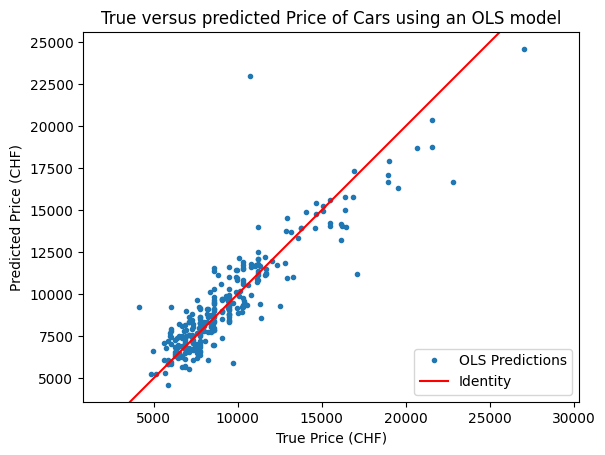

In [243]:
fig, ax = plt.subplots()

ax.plot(y_test, model.predict(X_test_std), ".", label="OLS Predictions")
ax.axis('equal')

ax.axline((mean_y_test, mean_y_test), slope=1, c='red', label="Identity")

ax.set_xlabel("True Price (CHF)")
ax.set_ylabel("Predicted Price (CHF)")
ax.set_title("True versus predicted Price of Cars using an OLS model")
ax.legend()
plt.show()

3. (2 pts) Report the R² score on the test dataset and interpret it.


In [244]:
display(Latex(f"$R^2_{{test}} = {r2_score(y_test, model.predict(X_test_std)):.3f}$"))

<IPython.core.display.Latex object>

**Answer**

Here, we see that the trained model has an $R^2$ score of 0.812. This implies that the trained model explains 81.2% of the variance observed in the test data, a relatively good score.

4.  (2 pts) Which features are statistically significant at a 5% significance level? 

In [245]:
stat_significant_features = model.params[(model.pvalues <= 0.05).values].to_frame(name="coefficient")
stat_significant_features.index.name = "statistically significant features (p <= 0.05)"
display(stat_significant_features)

,coefficient
statistically significant features (p <= 0.05),
const,9441.498258
Age,-1971.973191
Mileage,-503.558069
HP,476.619630
CC,-477.043150
Weight,1152.956431
FuelType_Diesel,444.707737
FuelType_Petrol,373.541532


5.  (2 pts) Determine which two feature have the highest coefficient? What does it imply?

In [246]:
stat_significant_features = stat_significant_features.sort_values("coefficient", key=abs, ascending=False)
display(stat_significant_features.iloc[:3])

,coefficient
statistically significant features (p <= 0.05),
const,9441.498258
Age,-1971.973191
Weight,1152.956431


**Answer**

The two most significant parameters with the highest coefficients are `const` and `Age`. Without `const` the two highest coefficients are `Age` and `Weight`. From above, all three are statistically significant in the model.

This implies that, in our model, `Age` and `Weight` have the most impact on car price (outside of the constant regressor):
- Increasing age by one standard deviation decreases price by ~CHF 1972, when all other features are fixed.
- Increasing weight by one standard deviaton increases the price by ~CHF 1153 CHF, when all other features are fixed.

**2.3 (2 pts): Improvement Discussion**

- Suggest a few additional features that could potentially explain this remaining variance in the data ( at least 2 features).

**Answer**

Additional features could include car brand, car type (SUV, berline...) or even the color of the car for example. Adding these features could help increase the amount of explained variance in the data, leading to better price predictions.

**2.4 (2 pts): Identifying Confounding Variables**

The feature "Weight" shows a very low p-value and a high coefficient, but it doesn't seem to be a major factor for customers buying a second-hand car. You go to your mentor Tim to discuss this issue. Indeed, Tim suggests that never in his career has he seen a customer who asked for the weight of a car before buying it.
You suspect that there might be a confounding variable that is correlated with the car's weight and significantly influences its price.

- Suggest a possible confounding variable that may be correlated with the car's weight and significantly influence its price (it doesn't need to be a variable in the dataset). Explain why this variable could be a confounding variable.

**Answer**

Not all cars are built with the same purpose in mind, and therefore differ in construction.
These differences may be reflected in the weight of the car, but also in its price.
For example, the **body type** of a car (SUV, sedan, coupe, etc.) is highly influencial on the weight,
but also affects price (a small hatchback is generally heavier and less expensive than an SUV).
Also, the **construction material** changes weight and price simultaneously. For example, a car with
heavy-duty materials might be more expensive and heavier than a cheaply built aluminium car. Even features within the dataset may be confounded with weight and price. For example, we saw that cars with 5 **doors** have the highest mean price, but may also generally be heavier than cars with less doors. 
These examples show how the weight of the car is confounded with other variables, and thus may not be as influencial as proposed by the model to predict price in actuality.

**2.5 (2 pts): Adding an Inverse Mileage Term**

From the previous scatter plot, the relationship between car price and mileage appears non-linear, with a steep price drop initially and then a flattening. A suitable approach to model this behavior is by incorporating an inverse term of mileage.

- Add the inverse mileage term to the model and retrain it using the code provided. Print the model summary and interpret the effect of the inverse mileage term.
  

In [247]:
data_ohe_inv_mile = data_ohe.copy(deep=True)
data_ohe_inv_mile["Inv_Mileage"] = 1/data_ohe_inv_mile["Mileage"]

X, y = seperate_features_from_target(data_ohe_inv_mile, target_name="Price")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)
X_train_std, X_test_std = standardize_features(X_train, X_test, add_constant=True)

reg = sm.OLS(endog=y_train, exog=X_train_std, hasconst=True)
np.random.seed(42)
model = reg.fit()

print(model.summary())
display(Latex(f"$RMSE_{{test}} = {root_mean_squared_error(y_test, model.predict(X_test_std)):.3f}$ (CHF)"))
display(Latex(f"$R^2_{{test}} = {r2_score(y_test, model.predict(X_test_std)):.3f}$"))

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     496.1
Date:                Wed, 27 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:29:26   Log-Likelihood:                -9801.7
No. Observations:                1148   AIC:                         1.963e+04
Df Residuals:                    1134   BIC:                         1.970e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            9441.4983     36.685    2

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

**Answer**

By adding the inverse mileage as a term in the model, the explained variance on the test data ($R_{test}^2$ increases from 81.2% to 81.3%. The increase (0.01%) is thus very small. Furthermore, the effect of the inverse mileage term is statistically non-significant at a 5% level (p=0.062). Thus, we observe that adding the inverse mileage term is not really beneficial for the model in predicting car prices.

## Part 3 Supervised Learning (40 pts)


After completing your analysis, you're satisfied with the results. You handed the Jupyter notebook over to your mentor.

(Fun fact: The name "Jupyter" is derived from Julia, Python, and R—three programming languages that the platform was originally designed for.)

Your mentor Tim is very impressed with your work and asks you the following question:

“
This looks great! It will be very useful for our sales team. While looking at the results, I realized that there might be one thing that we can improve. 
For companies like us, it is important to sell the cars quickly. If we are patient, we might be able to sell the car for a higher price, but that’s not always the best strategy. We need to consider the maintenance costs for the car, the cash flow and the fact that the price of the car decreases over time."

He then continues:
"Three months is a sweet spot for us. If we can sell the car within the first three months, it is great. If not, it is worth considering lowering the price to sell it faster and increase our cash flow. I can ask Ivan from Sales to collect data in the last few months on whether the car was sold within the first three months or not. This would be great if you could have a model that tells us if the car will be sold in the first three months or not. "

This sparks your interest, and soon Ivan has provided you with the new data containing an additional column `sold_within_3_months` which is a binary variable indicating whether the car was sold within the first three months or not.

Note: The data for this part is in the file `Task3.ToyotaCorolla_sales_3months.csv` and it has already unified the currency and distance units.

In [248]:
data_df = pd.read_csv('data/Task3.ToyotaCorolla_sales_3months.csv', index_col=0)
display(data_df)

,Price,Age,KM,FuelType,HP,MetColor,Automatic,CC,Doors,Weight,sold_within_3_months
0,13500,23,46986,Diesel,90,1,0,2000,3,1165,0
1,13750,23,72937,Diesel,90,1,0,2000,3,1165,0
2,13950,24,41711,Diesel,90,1,0,2000,3,1165,0
3,14950,26,48000,Diesel,90,0,0,2000,3,1165,0
4,13750,30,38500,Diesel,90,0,0,2000,3,1170,0
...,...,...,...,...,...,...,...,...,...,...,...
1431,7500,69,20544,Petrol,86,1,0,1300,3,1025,1
1432,10845,72,19000,Petrol,86,0,0,1300,3,1015,0
1433,8500,71,17016,Petrol,86,0,0,1300,3,1015,1
1434,7250,70,16916,Petrol,86,1,0,1300,3,1015,1



**3.1 (2 pts): Preprocess the Data**
1. （1 pts）How many cars in the dataset were sold in the first three months, and how many were not? 

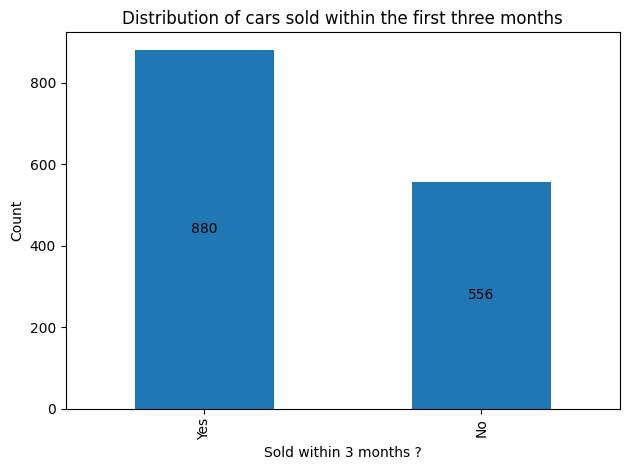

In [249]:
fig, ax = plt.subplots()
data_df["sold_within_3_months"].value_counts().plot(kind="bar", ax=ax)

for bar_container in ax.containers:
    ax.bar_label(
        bar_container,
        label_type="center",
    )

ax.set_xlabel(ax.get_xlabel().capitalize().replace("_", " ") + " ?")
ax.set_xticklabels(["Yes", "No"])
ax.set_ylabel("Count")
ax.set_title("Distribution of cars sold within the first three months")
plt.tight_layout()
plt.show()

2. (1 pts) Preprocess the categorical variables to one-hot encoding using the `pd.get_dummies()` function.

In [250]:
data_df_ohe = pd.get_dummies(data=data_df, drop_first=True, columns=["FuelType", "Doors"], dtype=int)
display(data_df_ohe)

,Price,Age,KM,HP,MetColor,Automatic,CC,Weight,sold_within_3_months,FuelType_Diesel,FuelType_Petrol,Doors_3,Doors_4,Doors_5
0,13500,23,46986,90,1,0,2000,1165,0,1,0,1,0,0
1,13750,23,72937,90,1,0,2000,1165,0,1,0,1,0,0
2,13950,24,41711,90,1,0,2000,1165,0,1,0,1,0,0
3,14950,26,48000,90,0,0,2000,1165,0,1,0,1,0,0
4,13750,30,38500,90,0,0,2000,1170,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,7500,69,20544,86,1,0,1300,1025,1,0,1,1,0,0
1432,10845,72,19000,86,0,0,1300,1015,0,0,1,1,0,0
1433,8500,71,17016,86,0,0,1300,1015,1,0,1,1,0,0
1434,7250,70,16916,86,1,0,1300,1015,1,0,1,1,0,0


**3.2 (20 pts): Logistic Regression Model**

1. (2 pts) Split the data into features (X) and target (y) variables. The target variable is the 'sold_within_3_months' column. The `Price` column should be included as a feature.

In [251]:
X, y = seperate_features_from_target(data_df_ohe, target_name="sold_within_3_months")

2. (2 pts) Then split the data into train test sets using a 80-20 split. Use `random_state=42` for reproducibility. 

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1148, 13), (288, 13), (1148, 1), (288, 1))

3. (2 pts) Standardize the features using `StandardScaler` from `sklearn.preprocessing` and then add a constant column using `sm.add_constant()`.

In [253]:
X_train_std, X_test_std = standardize_features(X_train, X_test, add_constant=True)

4. (2 pts) Fit a logistic regression model on the training dataset.

In [254]:
logit_reg = LogisticRegression(fit_intercept=False).fit(X_train_std, y_train.to_numpy().flatten())

5. (2 pts) Evaluate the model on the test dataset using the accuracy score metric. Report the accuracy score.

In [255]:
predicted_labels = logit_reg.predict(X_test_std)
true_labels = y_test.to_numpy().flatten()
print(f"Test Accuracy = {accuracy_score(predicted_labels, true_labels):.3f}")

Test Accuracy = 0.931


6. (2 pts) Calculate the precision, recall, and F1-score.

In [256]:
print("Evaluated on Test set :")
for sklearn_score in [precision_score, recall_score, f1_score_sk]: # justified with ed thread #444
    print(f"\t• {sklearn_score.__name__.capitalize().replace('_', ' ')} = {sklearn_score(true_labels, predicted_labels):.3f}")

Evaluated on Test set :
	• Precision score = 0.933
	• Recall score = 0.954
	• F1 score = 0.943



7. (2 pts) Suppose that your company is running short on cash flow and needs to sell the cars quickly. How should you adjust the threshold for the logistic regression model to ensure that the company can sell the cars as quickly as possible?
    - A. Increase the threshold
    - B. Decrease the threshold

In a more general sense, how does the choice of threshold affect the precision and recall of the model?

**Answer**

The sales team will apply discounts if it is predicted that there are not enough early (3 months) sales. Thus, to increase cash flow by increasing early sales, we need the model to predict more late sales ("negative" predictions), to force the sales team to increase discounts. Thus, we need to **increase the threshold**, as any probabiility under the threshold is classified as "negative". 

More generally, as shown in the figure below, with an increasing threshold, there is an increasing precision and a decreasing recall.

8. (6 pts) Use binary search to find the optimal threshold that maximizes the F1-score. Implement a binary search algorithm to find the threshold that maximizes the f1-score of the logistic regression model on the training set. The search interval should be between 0 and 1, and the stopping criterion is 10 iterations.  What is the optimal threshold and what difference does the optimal threshold make in the F1-score?

In [257]:
thresholds = np.arange(0, 1, 0.005).reshape(-1, 1)
probas = np.tile(logit_reg.predict_proba(X_test_std)[:, 1], (thresholds.shape[0], 1)) # tiled probabilities of class 1
predictions = (probas > thresholds).astype(int) # Broadcasting
scores = [
    {
        custom_score.__name__:custom_score(true_labels, predicted_labels)
        for custom_score in [accuracy, f1_score, precision, recall]
        
    }
    for predicted_labels in predictions
]
scores_df = pd.DataFrame(scores, index=thresholds.flatten()).dropna()
scores_df.index.name = "threshold"

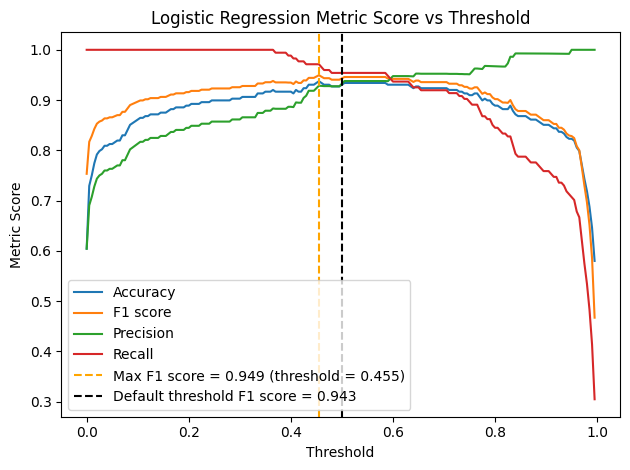

In [274]:
fig, ax = plt.subplots()
for column_name in scores_df:
    ax.plot(scores_df.index, scores_df[column_name], label=column_name.capitalize().replace('_', ' '))
ax.set_xlabel("Threshold")
ax.set_ylabel("Metric Score")
ax.set_title("Logistic Regression Metric Score vs Threshold")
ax.axvline(scores_df["f1_score"].idxmax(), color="orange", linestyle="--", label=f"Max F1 score = {scores_df['f1_score'].max():.3f} (threshold = {scores_df['f1_score'].idxmax()})")
ax.axvline(0.5, color="black", linestyle="--", label=f"Default threshold F1 score = {scores_df.loc[0.5,'f1_score']:.3f}")
ax.legend()
plt.tight_layout()
plt.show()

**Answer**

As seen in the above figure, we find that the optimal threshold is 0.455, yielding an F1 score of 0.949. In comparison, the default threshold of 0.5 yields an F1 score of 0.943, which is a 0.6 % decrease. Thus, changing the threshold is only very slightly beneficial.

**3.3(18 pts) Decision Tree Model**

Use a Decision Tree model from `sklearn` to predict whether a car will be sold within the first three months.

Follow these steps to complete the task:

1. (2 pts) Train a Decision Tree Classifier to predict the target variable (`sold_within_3_months`).You can reuse the train and test sets from the previous section. Set `random_state=42` for reproducibility in `DecisionTreeClassifier`.

In [259]:
default_tree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

2. (2 pts) Evaluate the model on the test set and report the depth of the tree.

In [260]:
def tree_assessment(max_depth:int|None, X_train:pd.DataFrame, y_train:np.ndarray, X_test:pd.DataFrame, y_test:np.ndarray, verbose:bool=True)->tuple[DecisionTreeClassifier, dict[str, float]]:
    dtree = DecisionTreeClassifier(random_state=42, max_depth=max_depth).fit(X_train, y_train)

    pred = dtree.predict(X_test)
    depth = dtree.get_depth()
    
    assessments = {
        custom_score.__name__:custom_score(y_test, pred)
        for custom_score in [accuracy, f1_score, precision, recall]
    }
    
    if verbose:
        print(f"Depth of the tree: {depth}")
        for score, value in assessments.items():
            print(f"\t• {score.capitalize().replace('_', ' ')} : {value:.3f}")

    return dtree, assessments

In [261]:
default_tree, _ = tree_assessment(None, X_train_std, y_train.to_numpy().flatten(), X_test_std, y_test.to_numpy().flatten())

Depth of the tree: 17
	• Accuracy : 0.917
	• F1 score : 0.932
	• Precision : 0.921
	• Recall : 0.943


3. (2 pts) Visualize the Decision Tree

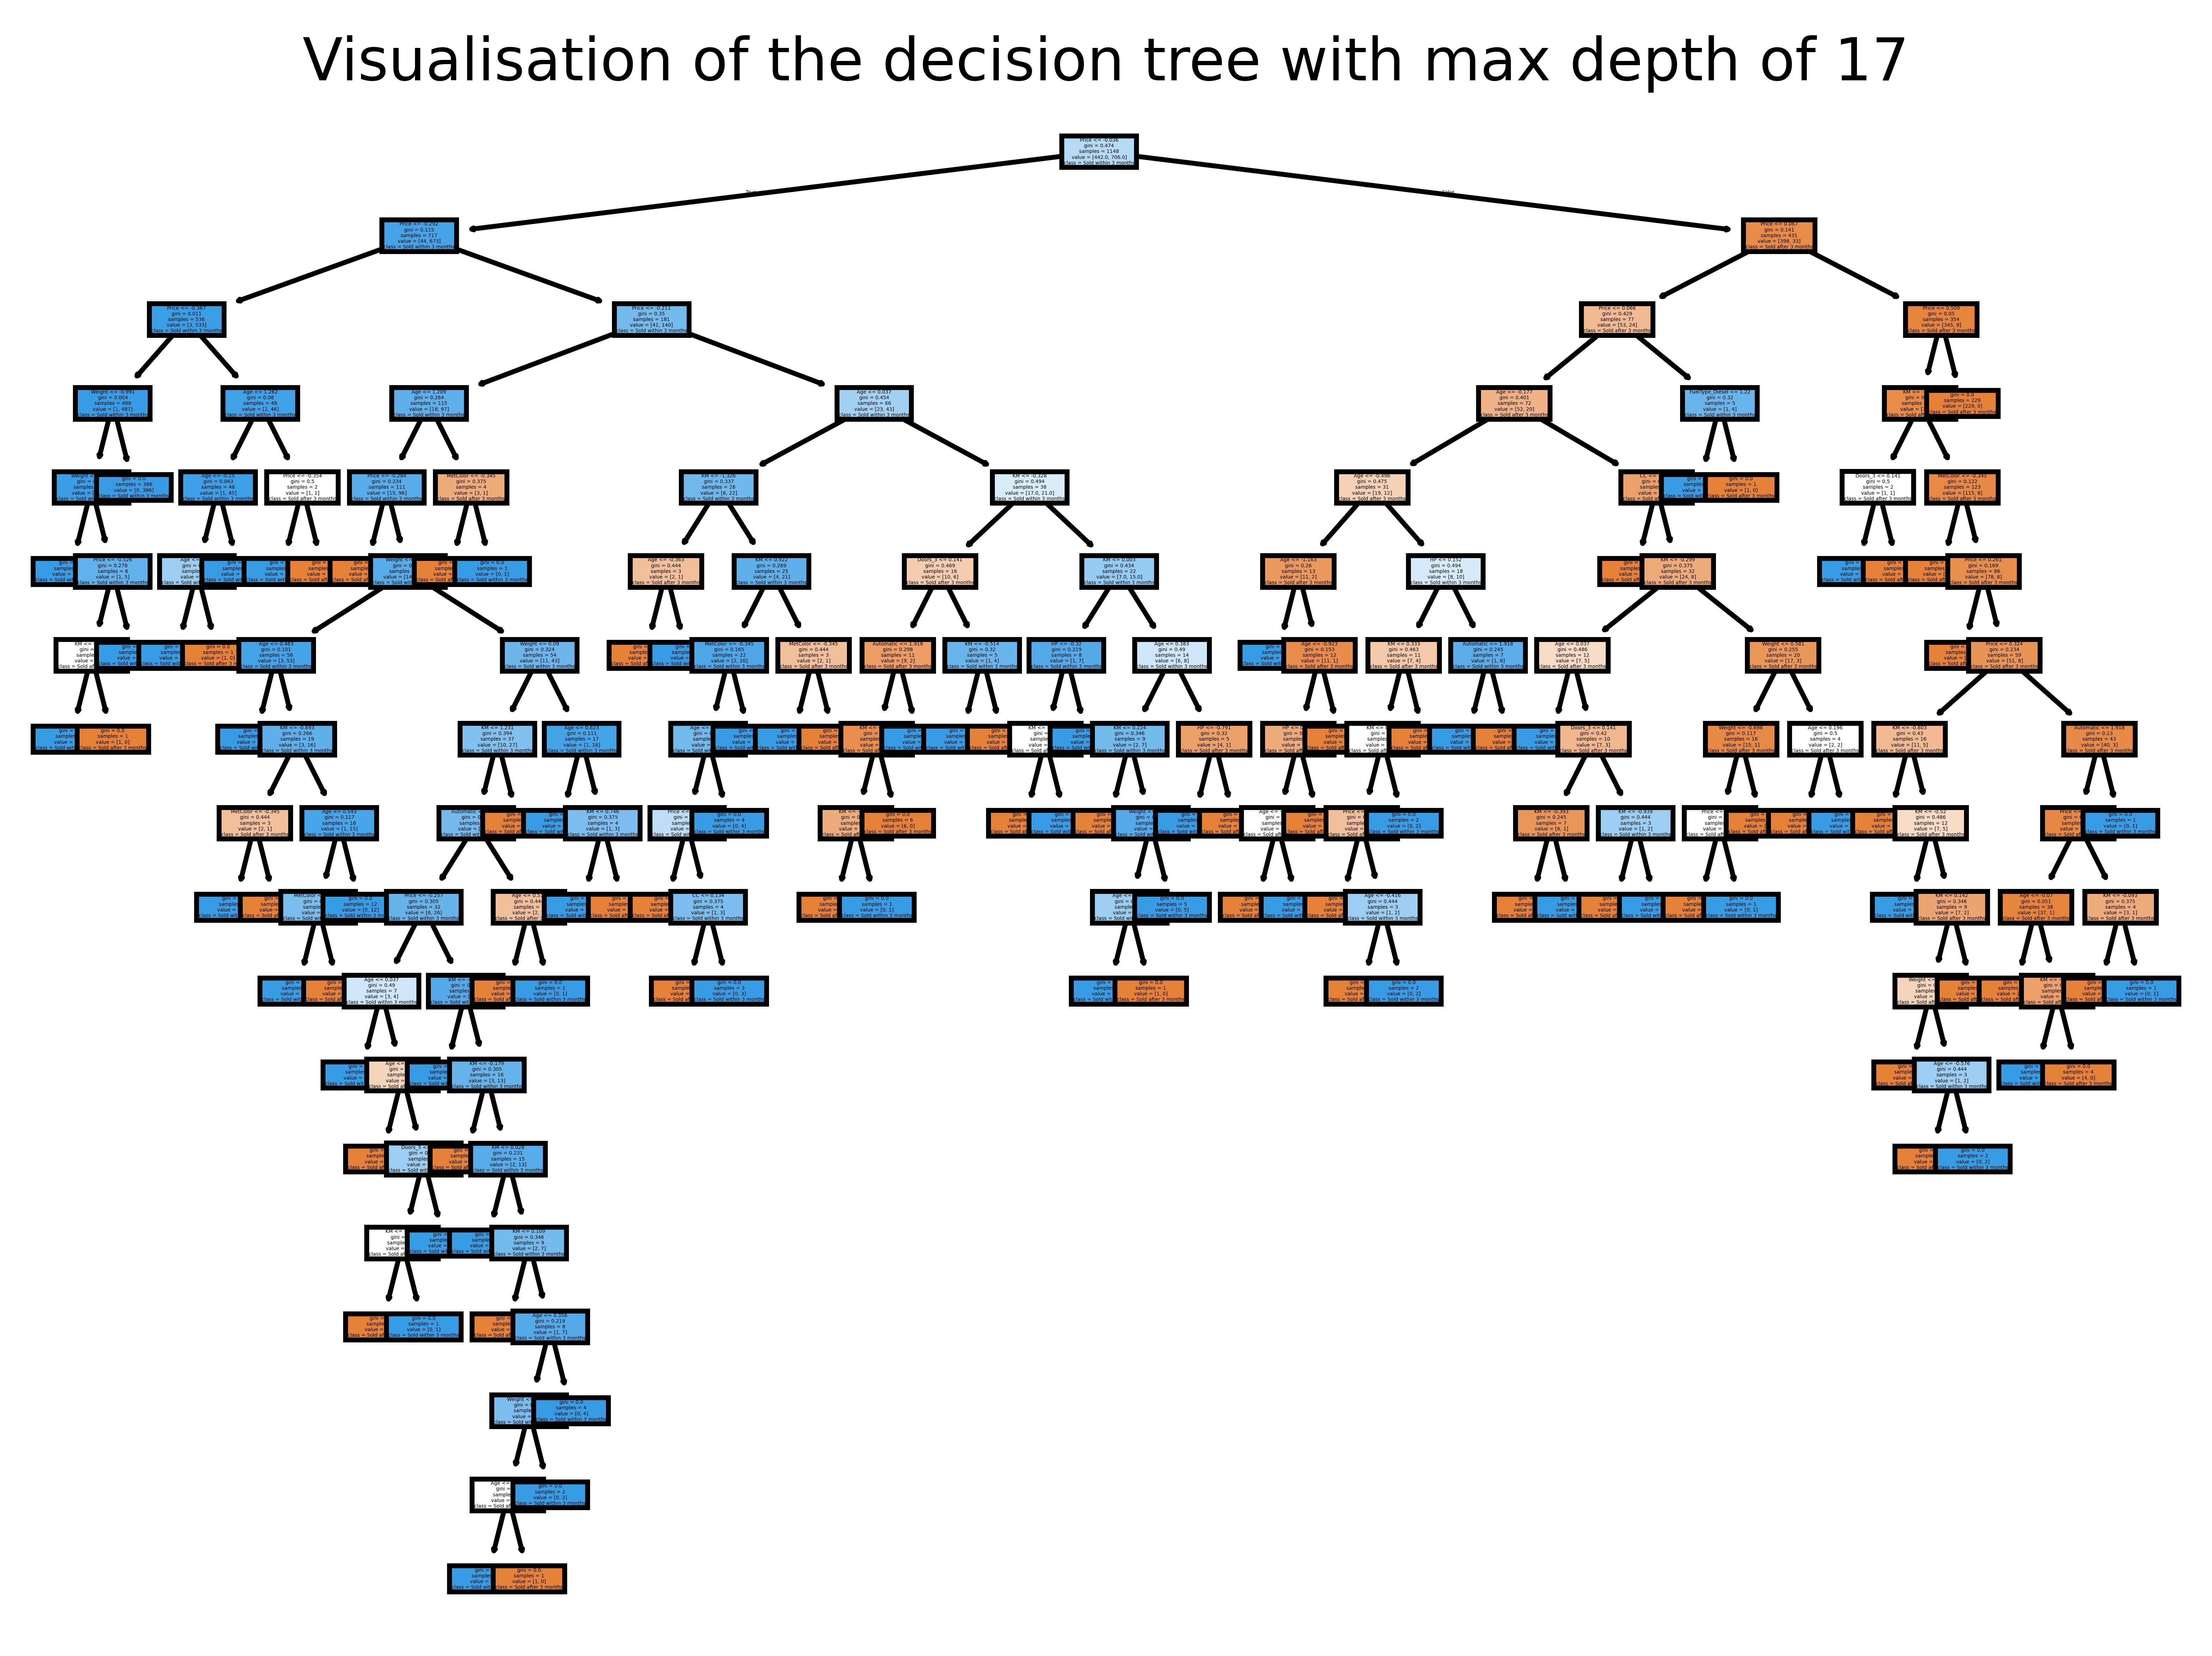

In [262]:
fig, ax = plt.subplots(dpi=1000)
plot_tree(default_tree, ax=ax, feature_names=default_tree.feature_names_in_, filled=True, class_names=np.array(["Sold after 3 months", "Sold within 3 months"])[default_tree.classes_])
ax.set_title(f"Visualisation of the decision tree with max depth of {default_tree.get_depth()}")
plt.tight_layout()
plt.show()

4. (2 pts) Retrain the Decision Tree Classifier with a maximum depth of 8 and evaluate it on the test set. Compare and explain the results.

In [263]:
tree_depth_8, _ = tree_assessment(8, X_train_std, y_train.to_numpy().flatten(), X_test_std, y_test.to_numpy().flatten())

Depth of the tree: 8
	• Accuracy : 0.917
	• F1 score : 0.933
	• Precision : 0.912
	• Recall : 0.954


**Answer**

From the output of the cells 3.2.2 and 3.2.4:

|   depth |   accuracy |   f1_score |   precision |   recall |
|--------:|-----------:|-----------:|------------:|---------:|
|       8 |      0.917 |      0.933 |       0.912 |    0.954 |
|      17 |      0.917 |      0.932 |       0.921 |    0.943 |

As we can see there is nearly no difference in the accuracy and the f1 score when using a max depth of 8 or 17. There are very small variations in precision and recall. This implies that a tree does not need many branches to correctly classify this dataset. The effect of depth on the model's performance is shown below.

5. (6 pts) Train a Decision Tree Classifier for each depth from 1 to D where D is the maximum depth of the Decision Tree Classifier seen in the previous step. Evaluate each model on the test set and plot the accuracy of the models as a function of the depth and find the optimal depth.


In [264]:
tree_depth = list(range(1, default_tree.get_depth()+1))
depth_hyper_param_df = pd.DataFrame([tree_assessment(d, X_train_std, y_train.to_numpy().flatten(), X_test_std, y_test.to_numpy().flatten(), verbose=False)[-1] for d in tree_depth], index=tree_depth)
depth_hyper_param_df.index.name = "depth"

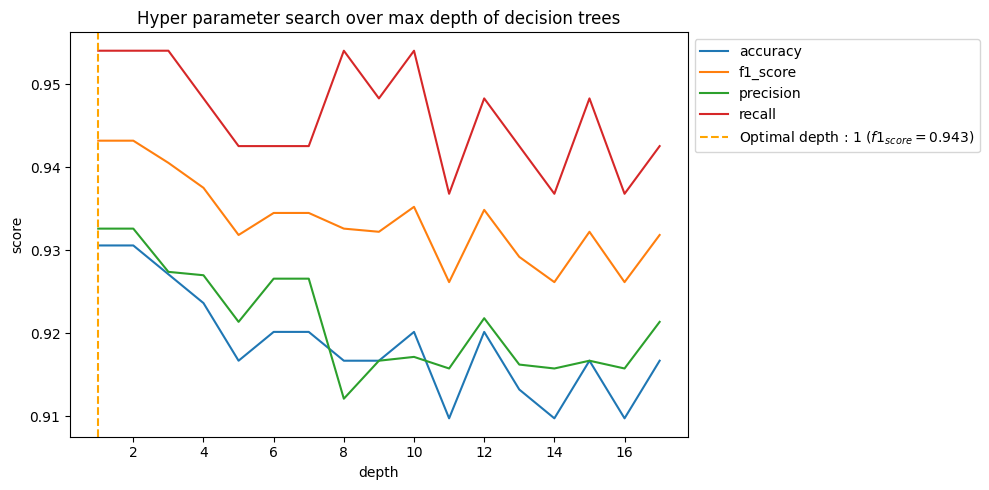

In [265]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_ylabel("score")

ax.set_title("Hyper parameter search over max depth of decision trees")

depth_hyper_param_df.plot(ax=ax)

optimal_depth = depth_hyper_param_df["f1_score"].idxmax()
ax.axvline(optimal_depth, linestyle="--", color="orange", label=f"Optimal depth : {optimal_depth} ($f1_{{score}} = {depth_hyper_param_df['f1_score'].max():.3f} $)")

ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Answer**

As we can see, the depths of the tree that maximize the $f1_{score}$ are both 1 and 2 ($f1_{score} = 94.3\%$). On the basis of model simplicity and interpretability, we prefer the use of a depth of 1 instead of 2. This simple model is explored below.

6. (4 pts) Train a decision tree of depth = 1 , visualize the tree and explain what is the decision rule at the root node.

Depth of the tree: 1
	• Accuracy : 0.931
	• F1 score : 0.943
	• Precision : 0.933
	• Recall : 0.954


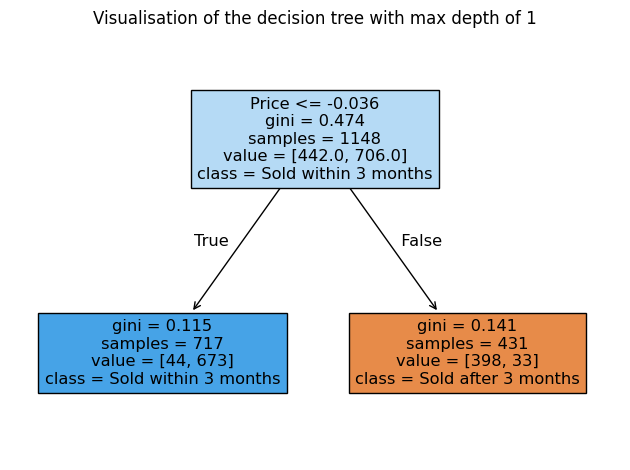

In [266]:
tree_depth_1, _ = tree_assessment(1, X_train_std, y_train.to_numpy().flatten(), X_test_std, y_test.to_numpy().flatten())

fig, ax = plt.subplots()
plot_tree(tree_depth_1, ax=ax, feature_names=tree_depth_1.feature_names_in_, filled=True, class_names=np.array(["Sold after 3 months", "Sold within 3 months"])[tree_depth_1.classes_])
ax.set_title(f"Visualisation of the decision tree with max depth of 1")
plt.tight_layout()
plt.show()

**Answer**

The decision rule at the root node is related to the `Price` of the car. We can see that if `Price <= -0.036` then the car is sold within three months, otherwise it is sold after three months. We know that the mean of the `Price` column is close to `0` (standardised), therefore, the decision rule `Price <= -0.036` approaches the rule that a price lower that the mean results in a sale within three months.

As shown in the previous plots, this rule is sufficient to classify the data with very good assessment metrics (see above), actually better than with deeper trees.

## Part 4 Propensity Score Matching (10 pts)

Your mentor is thrilled with the progress, and he has asked Ivan to put the model into production. Based on the model's prediction, the sales manager Ivan will decide whether to lower the car's price by 5%.

A new quarter has passed, and Ivan has collected updated sales data, which includes the following columns:

- `Price`: The initial price of the car.
- `Pred_Prob`: The predicted probability of the car being sold within the first three months.
- `Applied_Discount`: Whether the discount was applied (Yes=1, No=0).
- `Discounted_Price`: The car's final price, calculated as `Price * 95%` if the discount was applied; otherwise, it's equal to `Price`.
- `Sold_within_3_months`: Whether the car was sold within the first three months (Yes=1, No=0).

Your task is to estimate the causal effect of the discount on sales within the first three months using propensity score matching.

In [267]:
data_df = pd.read_csv('data/Task4.ToyotaCorolla_discount_sales.csv', index_col=0)
display(data_df.head())

,Price,Pred_Prob,Applied_Discount,Discounted_Price,Sold_within_3_months
0,12750,0.01,1,11475.0,1
1,21950,0.00,1,19755.0,1
2,9950,0.79,0,9950.0,1
3,9930,0.91,1,8937.0,0
4,9450,0.97,0,9450.0,0


**4.1 (1 pts): How many samples are in the treated group, and how many are in the control group?**

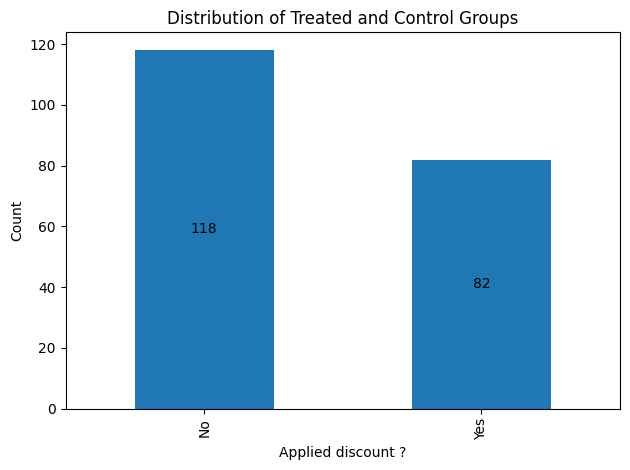

In [268]:
fig, ax = plt.subplots()
data_df["Applied_Discount"].value_counts().plot(kind="bar", ax=ax)

for bar_container in ax.containers:
    ax.bar_label(
        bar_container,
        label_type="center",
    )

ax.set_xlabel(ax.get_xlabel().capitalize().replace("_", " ") + " ?")
ax.set_xticklabels(["No", "Yes"])
ax.set_ylabel("Count")
ax.set_title("Distribution of Treated and Control Groups")
plt.tight_layout()
plt.show()


**4.2 (5 pts): Propensity Score Matching**
- The propensity score is the predicted probability of the car being sold within the first three months from the logistic regression model, i.e. `Pred_Prob` column in the `Task4.ToyotaCorolla_discount_sales.csv` file. Create pairs of matched samples as follows:
  - For each treated sample (discount applied), find a control sample (discount not applied) with a difference in propensity score of less than 0.05.
  - If there is more than one control sample for a treated sample, choose the control sample with the smallest difference in propensity score.
  - If there is no control sample satisfying the condition, discard the treated sample.
  - How many successful matches did you get?

Notice that your output should be 1-to-1 matching, meaning that each treated sample should be matched with at most one control sample.
So each sample can only appear once in the pairs.

In [269]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [270]:
# Separate the treatment and control groups
treatment_df = data_df.query("Applied_Discount == 1")
control_df = data_df.query("Applied_Discount == 0")

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Pred_Prob'],
                                    treatment_row['Pred_Prob'])

        if similarity > 0.95:
            # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Returns the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)
matching = np.array(sorted(matching))

In [271]:
balanced_df = data_df.iloc[matching.flatten()]
print(f"Got {balanced_df.shape[0]//2} matches.")
display(balanced_df)

Got 49 matches.


,Price,Pred_Prob,Applied_Discount,Discounted_Price,Sold_within_3_months
17,9950,0.83,0,9950.0,0
99,9950,0.83,1,8955.0,1
34,9950,0.91,0,9950.0,1
26,9750,0.91,1,8775.0,1
35,12950,0.00,0,12950.0,0
...,...,...,...,...,...
136,10750,0.36,1,9675.0,0
198,8500,0.99,0,8500.0,0
21,8950,0.99,1,8055.0,1
199,12900,0.00,1,11610.0,1


In [272]:
if balanced_df.index.is_unique:
    print("Each sample only appeared once in the pairs.")
else:
    raise ValueError("The index of the balanced dataframe is not unique.")

Each sample only appeared once in the pairs.


**4.3 (4 pts): Average Treatment Effect (ATE)**

Now let's estimate the effect of the discount on sales. 

For each matched pair, there is one treated sample and one control sample. They may have different outcomes and we can calculate the average treatment effect (ATE) as 

$$ ATE = \frac{1}{N} \sum_i^N  y_{treat}^{(i)} - y_{\\control}^{(i)} $$ 

where $y_{treat}^{(i)}$ and $y_{\\control}^{(i)}$ are the outcomes for the treated and control samples, respectively.

Notice that here the outcome is a simple binary variable, which is whether the car was sold within the first three months or not.

1. (3 pts) Calculate the ATE based on the matched pairs and report the result



In [273]:
ATE = np.mean(
    (
        balanced_df.query('Applied_Discount == 1')['Sold_within_3_months'].to_numpy() # y_treat vector
        - balanced_df.query('Applied_Discount == 0')['Sold_within_3_months'].to_numpy() # y_control vector
    )
)

display(Latex(f"$ATE = {ATE:.3f} $"))

<IPython.core.display.Latex object>

2. (1 pts) What is your conclusion about the effect of the discount on sales within the first three months?

**Answer**

The discount applied on cars has a positive effect on early sales (within the first three months) since the $ATE > 0$. Indeed, in our case, $ATE \in [-1, 1]$, where $ATE=1$ implies that the treatment completely positively changes early sales, and $ATE=-1$ implies that the treatment completely negatively changes early sales. Therefore, $ATE = 0.367$ is a relatively positive impact, showing that sales within the first three months are more frequent with discounts.